In [14]:
%matplotlib inline

# Домашнее задание

Урок 2. Representation learning

Заменить используемую сеть на менее "глубокую" (VGG-16)

Увеличить размер изображения, задав большее значение чем 256 (512)

Изменить соотношение стиля и контента (например, на 1000 к 1)

Сгенерировать стилизованное изображение, используя другие, выбранные вами изображения

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights, vgg19, VGG19_Weights

import copy

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cpu')

In [17]:
imsize = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./images/pastel.jpg")
content_img = image_loader("./images/white_cat.png")


assert style_img.size() == content_img.size(), \
    "Изображения должны быть одинакового размера, что-то пропущено в процедуре подготовки изображений"

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Дадим графику обновиться

In [20]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [21]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [22]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [23]:
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()
# cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [24]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [25]:
content_layers_default = ['conv_4']

style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i=0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

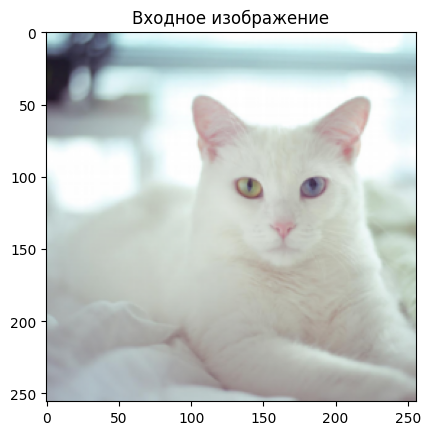

In [26]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Входное изображение')

In [27]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [28]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000, content_weight=100):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'run: {run}')

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)


    return input_img

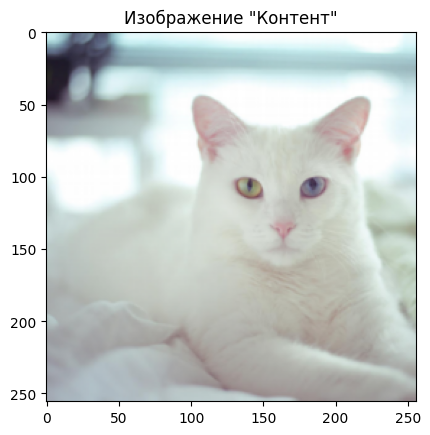

Построение модели переноса стиля..


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Оптимизируем картинку..
run: [50]
run: [100]
run: [150]
run: [200]
run: [250]
run: [300]


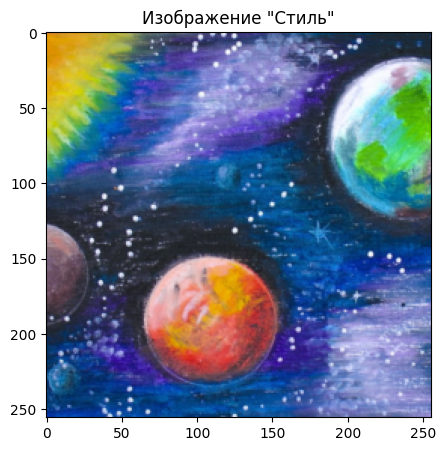

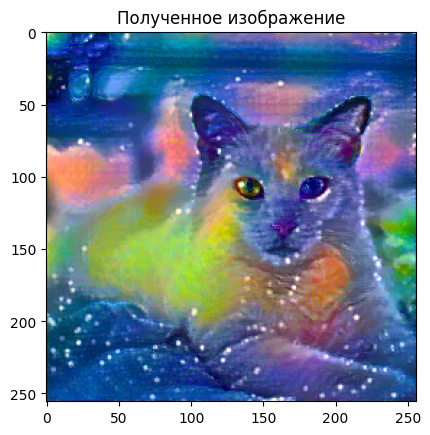

Построение модели переноса стиля..
Оптимизируем картинку..
run: [50]
run: [100]
run: [150]
run: [200]
run: [250]
run: [300]


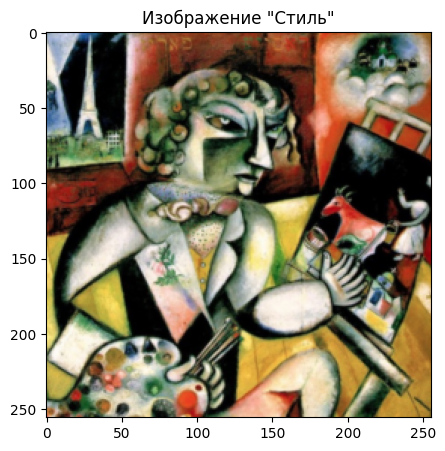

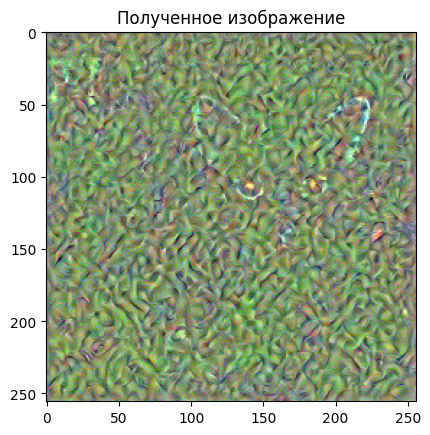

Построение модели переноса стиля..
Оптимизируем картинку..
run: [50]
run: [100]
run: [150]
run: [200]
run: [250]
run: [300]


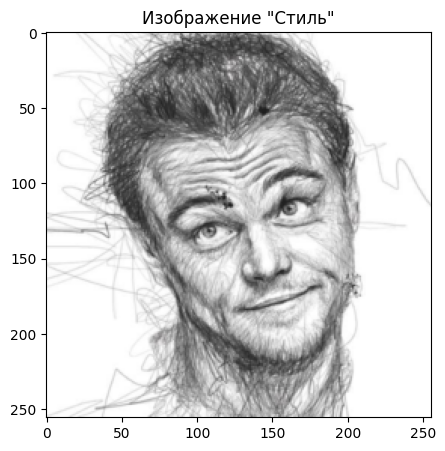

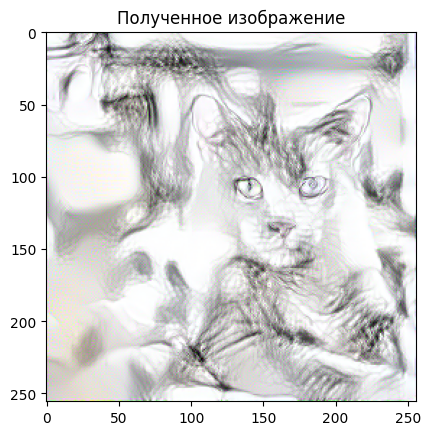

Построение модели переноса стиля..
Оптимизируем картинку..
run: [50]
run: [100]
run: [150]
run: [200]
run: [250]
run: [300]


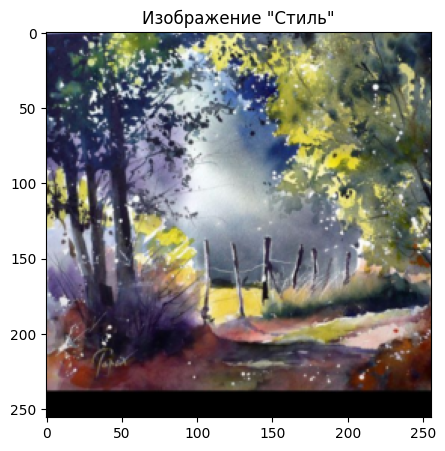

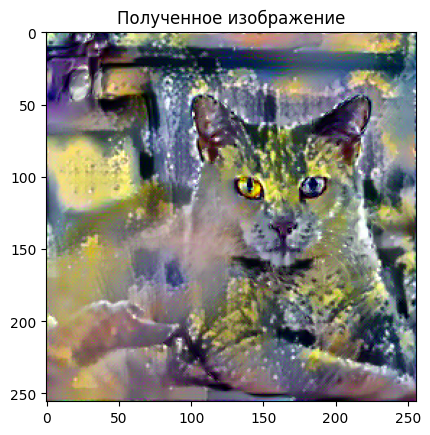

In [29]:

content_img = image_loader("./images/white_cat.png")

plt.figure()
imshow(content_img, title='Изображение "Контент"')

style = ['pastel.jpg', 'avangard.jpg', 'pencil.jpg', 'watercolor.jpg']

for img in style:
    style_img = image_loader(f"./images/{img}")

    unloader = transforms.ToPILImage()

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img, num_steps=300,
                                style_weight=100000, content_weight=1)

    plt.figure(figsize=(10,5))
    imshow(style_img, title='Изображение "Стиль"')
    imshow(output, title='Полученное изображение')

    plt.ioff()
    plt.show()




### Вывод.
Целью данной работы было научиться работать с эмбедингами и готовыми моделями нейросети. Для контентной модели было использовано изображение белого кота. В ходе работы стояла задача применить разные стили для изменения изображение. Я применил 4 техник рисования (акварель, пастель, карандаш и авангард). Лучше всего к исходному изображению применились стили пастель и акварель. Также было изменено соотношение стиля и контента на 100000 к 1 (а не 1000 к 1, как было в задании), тк изображения не рисовались, оставались одни пиксели